In [11]:
using Printf
using Statistics
using Random
using Pkg
using Distributions
using Plots
using SpecialFunctions
using StatsBase
using CSV
using DataFrames
using Metrics
using GLM
using StatsPlots

In [12]:
Random.seed!(69)

TaskLocalRNG()

## Question 1

$\textrm{The  Posterior  Distribution } \mathrm{\pi\big((\mu,\nu)| X\big)} \textrm{ is  given  as  follows:}$
$$\mathrm{\pi\big((\mu,\nu)| X\big) = f\big(X | (\mu,\nu)\big)f(\mu | \nu) f(\nu)}$$
$$\textrm{where: }\mathrm{f\big(X | (\mu,\nu)\big) \propto \prod\Big(\exp\big(\frac{(x_{i}-\mu)^2}{2}\big)\Big)} $$
$$\mathrm{f(\mu | \nu) \propto \big(1+\frac{\mu^2}{\nu}\big)^{(\frac{-\nu+1}{2})}} $$
$$\mathrm{f(\nu) \propto (\nu b_{0})^{(a_{0}-1)}\exp(-b_{0}\nu)}$$
$\textrm{and since} \textit{ Truncated Gamma} \mathrm{(a_{0},b_{0},(2,\infty))}\textrm{ is defined only in } \mathrm{(2,\infty)}$
$$\mathrm{\implies\pi\big((\mu,\nu)| X\big) = 0}\textrm{ for }\mathrm{ x \in (-\infty,2)}$$
$$\mathrm{\implies\pi\big((\mu,\nu)| X\big)=\prod\Big(\exp\big(\frac{(x_{i}-\mu)^2}{2}\big)\Big)\big(1+\frac{\mu^2}{\nu}\big)^{(\frac{-\nu+1}{2})}(\nu b_{0})^{(a_{0}-1)}\exp(-b_{0}\nu)}$$
$\textrm{So we can write a Metropolis Hastings Algorithm to sample from the above distribution:}$
1. $\textrm{Set }\mathrm{y_{1}=\frac{\sum x_{i}}{100} = mean(x_{i})}$
2. $\textrm{Draw }\mathrm{y^*}\textrm{ from our proposal distribution, which is }\mathrm{N(\mu,h)}$
3. $\textrm{Find }\mathrm{\alpha = min\big\{1,\frac{\pi(y^*)}{\pi(y_{t-1})}\big\}}$
4. $\textrm{Draw }\mathrm{u \sim U[0,1]}$
5. $\textrm{if u < }\mathrm{\alpha}\textrm{, set }\mathrm{y_{t}=y^*}$
6. $\textrm{else set }\mathrm{y_{t}=y_{t-1}}$



In [13]:
function postDistribution(a_not,b_not,nu,mu,x)
    len=size(x)[1]
     
    val=(1+(mu^2)/nu)^(-(nu+1)/2)*(nu*b_not)^(a_not-1)*exp(-nu*b_not)
    
    for i in 1:len
        val=val*exp(-((x[i]-mu)^2)/2)
    
    end
    return val
end 

postDistribution (generic function with 1 method)

In [14]:
num_samples=10000;
a_not=2
b_not=0.1
nu=rand(truncated(Gamma(a_not,b_not),lower=2),1)[1]
mu=rand(TDist(nu),1)[1]
h=0.46

0.46

In [15]:
samples=zeros(num_samples,1)

data=zeros(100,1)
for i in 1:100
    data[i]=rand(Normal(mu,1))
end 
samples[1]=mean(data)
accepted=0
for i in 2:num_samples
    prop=rand(Normal(samples[i-1],h))
    ratio=postDistribution(a_not,b_not,nu,prop,data)/postDistribution(a_not,b_not,nu,samples[i-1],data)
    t=rand(Uniform(0,1))
  
    if(t<ratio)
        samples[i]=prop
        accepted=accepted+1
    else
        samples[i]=samples[i-1]
    end 
end



In [16]:
println("Mean of samples drawn using MCMC: ", string(mean(samples)))
println("Mean of initial data: ", string(mean(data)))

Mean of samples drawn using MCMC: -0.12915783007836973
Mean of initial data: -0.12922657070348487


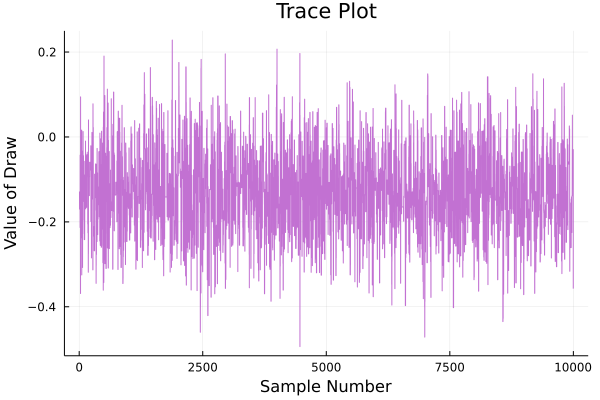

In [17]:
plot((samples),color=4,label="", xlabel="Sample Number", ylabel="Value of Draw", title="Trace Plot")

In [18]:
println("Acceptance Rate: ", string(accepted/100))

Acceptance Rate: 25.78


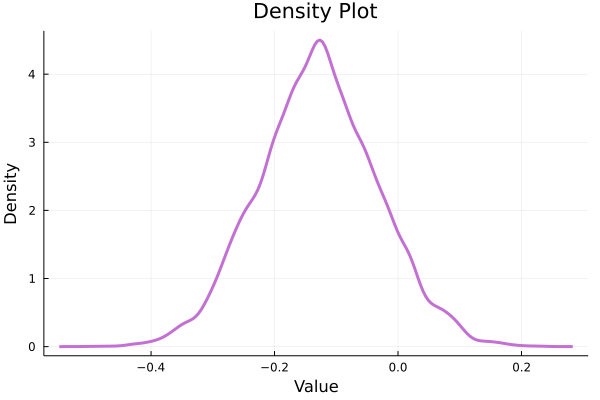

In [19]:
plot(density(samples,color=4,label="",lw=3), title="Density Plot", xlabel="Value", ylabel="Density")

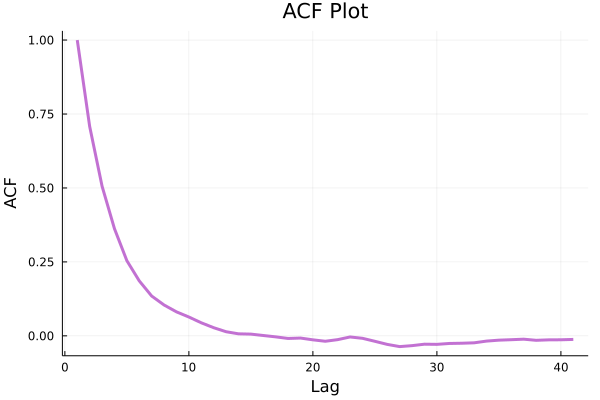

In [20]:
plot(autocor(samples),lw=3,color=4,label="",xlabel="Lag",ylabel="ACF",title="ACF Plot")

## Question 3
$\textrm{The  Posterior  Distribution } \mathrm{\pi\big((\beta,\sigma^2)| X, Y\big)} \textrm{ is  given  as  follows:}$
$$\mathrm{\pi\big((\beta,\sigma^2)| X,Y\big) \propto f\big(Y | (\beta,\sigma^2,X)\big)f(\beta | \sigma^2) f(\sigma^2)}$$
$$\textrm{where: }\mathrm{f\big(Y | (\beta,\sigma^2,X)\big) \propto (\sigma^2)^{(-\frac{n}{2})}\Big(\exp\big(-\frac{(Y-X\beta)^\intercal(Y-X\beta)}{2\sigma^2}\big)\Big)} $$
$$\mathrm{f(\beta | \sigma^2) \propto (\sigma^2)^{(-p/2)})\big(\frac{((\beta-\mu)^\intercal(\beta-\mu)}{2\sigma^2}\big)}$$
$$\mathrm{f(\sigma^2) \propto (\sigma^2)^{(a+1)}\exp(\frac{-b}{\sigma^2})}$$
$$\therefore\mathrm{\pi\big((\beta,\sigma^2)| X, Y\big)=(\sigma^2)^{(-\frac{n}{2})}\Big(\exp\big(-\frac{(Y-X\beta)^\intercal(Y-X\beta)}{2\sigma^2}\big)\Big)(\sigma^2)^{(-p/2)})\big(\frac{((\beta-\mu)^\intercal(\beta-\mu)}{2\sigma^2}\big)}(\sigma^2)^{(a+1)}\exp(\frac{-b}{\sigma^2})$$

$\textrm{Dateset used: Boston Housing dataset with 50 observations and 12 features. To generate the first sample, I applied linear regression}$ 
$\textrm{on the data and obtained the coeffecients. This will be the first sample as it is the MLE.}$
$\textrm{So we can write a Metropolis Hastings Algorithm to sample from the above distribution. Let }\mathrm{s_{1},s_{2}.....s_{num\_samples}}\textrm{ be the samples.}$
1. $\textrm{Set }\mathrm{s_{1}}\textrm{the coeffecients of linear regression on X }$
2. $\textrm{Draw }\mathrm{s^*}\textrm{ from our proposal distribution, which is }\mathrm{N_{p}(s_{t-1},I_{p}\sigma^2)}$
3. $\textrm{Find }\mathrm{\alpha = min\big\{1,\frac{\pi(s^*)}{\pi(s_{t-1})}\big\}}$
4. $\textrm{Draw }\mathrm{u \sim U[0,1]}$
5. $\textrm{if u < }\mathrm{\alpha}\textrm{, set }\mathrm{s_{t}=s^*}$
6. $\textrm{else set }\mathrm{s_{t}=s_{t-1}}$



In [21]:
function postDistribution(a,b,mu,var,beta,x,y) #Function that returns the value of the pdf of Posterior Distribution
    n=size(y)[1]
    p=size(x)[2]
    temp1=sum((y.-x*beta).^2)
 
    temp2=sum((beta.-mu).^2)
    var=float(var)
    a=float(a)
    b=float(b)
    mu=float(mu)
    val=var^(-n/2)*exp(-temp1/(2*var))*var^(-p/2)*exp(-temp2/(2*var))*var^(-a-1)*exp(-b/var)
    return val
   
end 

postDistribution (generic function with 2 methods)

In [22]:
num_samples=10000 #Set variables
a=1
b=1
mu=1
var=rand(InverseGamma(a,b),1)[1]



1.5542754749886716

In [24]:
x=CSV.read("x.csv",DataFrame) #Load the Dataset (Boston Housing)
x=x[1:50,2:14]
x=Matrix(x)
x=x[:,1:end .!=4]



50×12 Matrix{Float64}:
 0.00632  18.0  2.31  0.538  6.575   65.2  …  1.0  296.0  15.3  396.9    4.98
 0.02731   0.0  7.07  0.469  6.421   78.9     2.0  242.0  17.8  396.9    9.14
 0.02729   0.0  7.07  0.469  7.185   61.1     2.0  242.0  17.8  392.83   4.03
 0.03237   0.0  2.18  0.458  6.998   45.8     3.0  222.0  18.7  394.63   2.94
 0.06905   0.0  2.18  0.458  7.147   54.2     3.0  222.0  18.7  396.9    5.33
 0.02985   0.0  2.18  0.458  6.43    58.7  …  3.0  222.0  18.7  394.12   5.21
 0.08829  12.5  7.87  0.524  6.012   66.6     5.0  311.0  15.2  395.6   12.43
 0.14455  12.5  7.87  0.524  6.172   96.1     5.0  311.0  15.2  396.9   19.15
 0.21124  12.5  7.87  0.524  5.631  100.0     5.0  311.0  15.2  386.63  29.93
 0.17004  12.5  7.87  0.524  6.004   85.9     5.0  311.0  15.2  386.71  17.1
 0.22489  12.5  7.87  0.524  6.377   94.3  …  5.0  311.0  15.2  392.52  20.45
 0.11747  12.5  7.87  0.524  6.009   82.9     5.0  311.0  15.2  396.9   13.27
 0.09378  12.5  7.87  0.524  5.889   39.0 

In [25]:
y=CSV.read("y.csv",DataFrame) #Load the dataset
y=y[1:50,"medv"]
y=y./sum(y)
p=size(x)[2]
for i in 1:p
    x[:,i]=x[:,i]./sum(x[:,i])
end

In [26]:
data=hcat(x,y) #Apply linear regression to find out of the weights, so that we can assign those values to the first sample
data=DataFrame(data,:auto)
fm=@formula(x13~x1+x2+x3+x4+x5+x6+x7+x8+x9+x10+x11+x12)
linearRegressor=lm(fm,data)
weights=coef(linearRegressor)[2:13]

12-element Vector{Float64}:
  -0.09105016057361712
   0.19686142753753919
   1.0242506687101711
  23.380929639261375
   1.5268407296704496
  -0.27876746659987445
  -0.20490816031400413
   1.0207854742649116
 -16.803137213751235
  -0.7470732120645847
   0.2119606951187874
  -0.011639659032782898

In [27]:
h=[0.8 0.8 1.0 0.4 0.7 0.9 0.7 0.7 0.4 0.7 0.7 0.7] #Set h for proposal values



1×12 Matrix{Float64}:
 0.8  0.8  1.0  0.4  0.7  0.9  0.7  0.7  0.4  0.7  0.7  0.7

In [28]:
samples=zeros(num_samples,p) #Run the Algorithm
samples[1,:]=weights
accepted=0
for i in 2:num_samples
    prop=zeros(p,1)
    for j in 1:p
        prop[j]=rand(Normal(samples[i-1,j],h[j]))
    end 
    ratio=postDistribution(a,b,mu,var,prop,x,y)/postDistribution(a,b,mu,var,samples[i-1,:],x,y)
   
    t=rand(Uniform(0,1))
        
    if(t<ratio)
        samples[i,:]=prop
        accepted=accepted+1
    else
        samples[i,:]=samples[i-1,:]
    end 
        
end

In [29]:

density_plots=[] 
acf_plots=[]
trace_plots=[]
for i in 1:p
    p1=plot(density(samples[:,i],color=4,label=""))
    p2=plot(samples[:,i],color=4,label="")
    p3=plot(autocor(samples[:,i]),color=4,label="")
    push!(density_plots,p1)
    push!(acf_plots,p3)
    push!(trace_plots,p2)
end

In [30]:
println("Acceptance Rate: ", string(accepted/100))

Acceptance Rate: 33.24


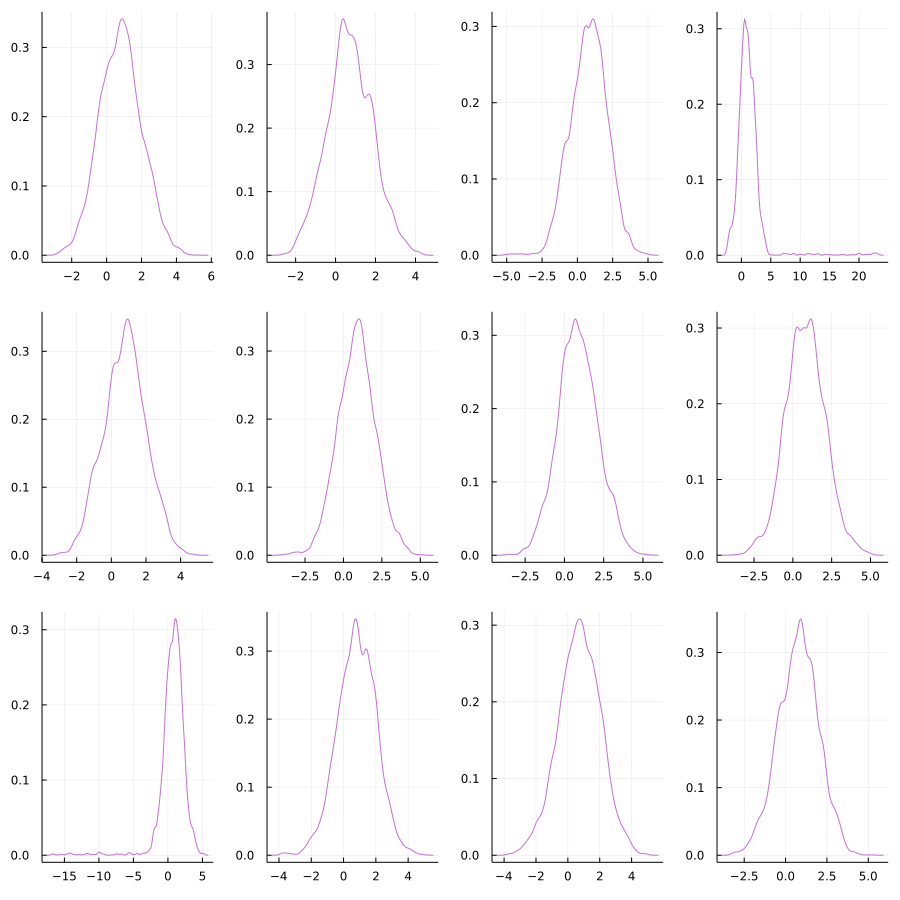

In [31]:
plot(density_plots...)
plot!(size=(900,900))

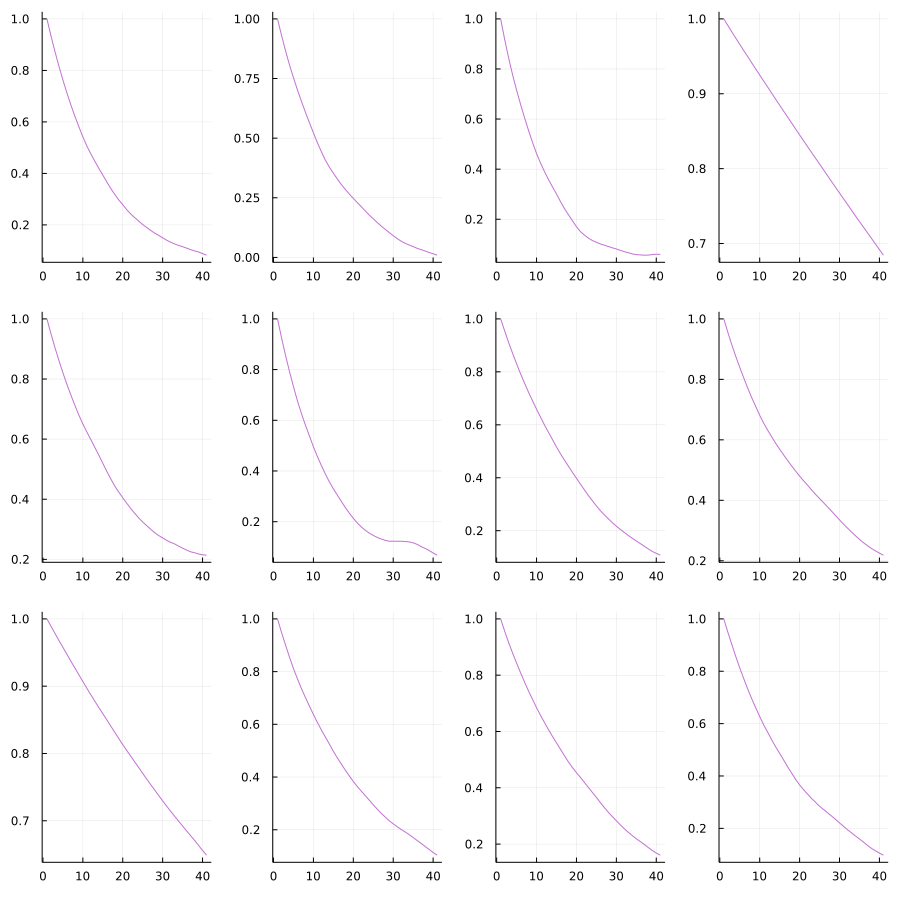

In [32]:
plot(acf_plots...)
plot!(size=(900,900))

In [33]:
plot(trace_plots...)
plot!(size=(900,900))

In [34]:
for i in 1:p
    println(mean(samples[:,i]))
end

0.81081679860565
0.7233601491259627
0.8008228539258476
1.2175803875287798
0.7833884679859358
0.8616413198033093
0.8657395755665697
0.8001751780999948
0.6832789793214296
0.815600623265495
0.7240154760571218
0.7724494629570697
